### Cosmological parameter inference from $\kappa$ maps with SBI

Predicting the posteriors of the two cosmological parameters, $\Omega_m$ -- $\sigma_8$, 

**Import packages**

In [1]:
#! apt-get update
#!sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super
#!pip install chainconsumer

In [2]:
#!pip install sbi

In [3]:
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils, inference
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
import numpy as np
import scipy as sp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

# Matplotlib, getdist, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# 
# # Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=12):
    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines
    return

plot_pretty()



In [4]:
# Import basic packages
import scipy as sp
import pandas as pd


# Colab in order to download files
from google.colab import files

# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chainconsumer
from chainconsumer import ChainConsumer

### Import datasets

In [5]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# IMAGE PATH
PLT_PATH = '/content/drive/My Drive/Maps_Project/Summary_January_2023/Plots/'

# MODEL WEIGHTS PATH
MDL_WEIGHTS_PATH = '/content/drive/My Drive/Maps_Project/Summary_January_2023/Saved_Models/'

# Define the data path
PATH = '/content/drive/My Drive/Maps_Project/Summary_January_2023/Datasets/'

In [7]:
# ============================= Labels ========================================= 

# Training
y_cosmo_train = np.float64(np.load(PATH+"ACTUAL_cosmo_params_jz1_runsC.npy"))[:,0:2]  
# Validation and Test
y_cosmo_valtest = np.float64(np.load(PATH+"ACTUAL_cosmo_params_jz1_runsE.npy"))[:,0:2] 

print(np.shape(y_cosmo_train))
print(np.shape(y_cosmo_valtest))

(19200, 2)
(9600, 2)


In [8]:
# Training 
X_maps_train = np.float64(np.load(PATH+"maps_jz1_runsC.npy")) # Redshift bin1
#X_train_bin2 = np.float64(np.load(PATH+"maps_jz2_runsC.npy")) # Redshift bin2

# Validation and Test
X_maps_valtest = np.float64(np.load(PATH+"maps_jz1_runsE.npy")) # Redshift bin1
#X_valtest_bin2 = np.float64(np.load(PATH+"maps_jz2_runsE.npy")) # Redshift bin2

In [9]:
#X_maps_train = np.stack([X_train_bin1,X_train_bin2],axis=-1) # Train 
#X_maps_valtest = np.stack([X_valtest_bin1,X_valtest_bin2],axis=-1) # Validation

# Delete the bin files
#del X_train_bin1, X_train_bin2, X_valtest_bin1, X_valtest_bin2

### Split into validation and test sets

In [9]:
# Data
X_maps_val = X_maps_valtest[0:4000]
X_maps_test = X_maps_valtest[4000:]

# Labels
y_cosmo_val = y_cosmo_valtest[0:4000]
y_cosmo_test = y_cosmo_valtest[4000:]

# Delete the valtest datasets now
del X_maps_valtest, y_cosmo_valtest

In [10]:
# Rescale the labels here 

# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler 
scaler.fit(y_cosmo_train)

# Rescale
y_train_sc = scaler.transform(y_cosmo_train)
y_val_sc = scaler.transform(y_cosmo_val)
y_test_sc = scaler.transform(y_cosmo_test)

In [11]:
print(np.shape(X_maps_train))
print(np.shape(y_train_sc))

(19200, 134, 134)
(19200, 2)


### Reshape maps to 32x32

In [12]:
from PIL import Image
from skimage.transform import resize

In [13]:
# Length/size of training set
leng_train = np.shape(X_maps_train)[0]
leng_test = np.shape(X_maps_test)[0]

print('Size of training set:',leng_train)
print('Size of test set:', leng_test)

Size of training set: 19200
Size of test set: 5600


In [14]:
X_train_resize = np.zeros([leng_train,32,32]) 
X_test_resize = np.zeros([leng_test,32,32])


# Reshape training set
for i in range(leng_train):
  X_map_i = X_maps_train[i]
  X_train_resize[i] = resize(X_map_i, (32,32))

# Reshape test set
for i in range(leng_test):
  X_map_i = X_maps_test[i]
  X_test_resize[i] = resize(X_map_i, (32,32))

**Let's plot a resized image**

(-0.5, 31.5, 31.5, -0.5)

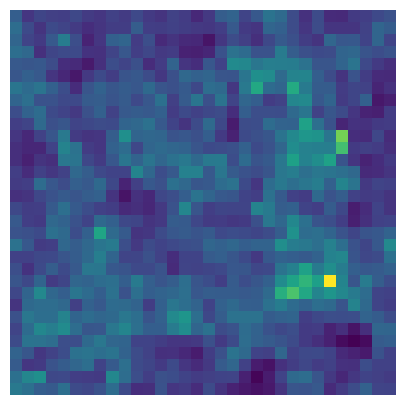

In [15]:
plt.figure(figsize=(10,5))
plt.imshow(X_test_resize[100],cmap='viridis')
plt.axis('off')

### Train the SPNE model



**First define a summary statistic model**

In [17]:
class SummaryNet(nn.Module): 
    
    def __init__(self): 
        super().__init__()
        # 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(32)
        
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.bn6 = nn.BatchNorm2d(128)

        # Maxpool layer that reduces 32x32 image to 4x4
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer taking as input the 6 flattened output arrays from the maxpooling layer
        self.fc = nn.Linear(in_features=128*4*4, out_features=48) 
        
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        
        x = (self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.pool(self.bn6(F.relu(self.conv6(x))))
        
        x = x.view(-1, 128*4*4)
        x = F.relu(self.fc(x))
        return x
        
embedding_net = SummaryNet().to('cuda:0')

from torchsummary import summary
summary(embedding_net, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
       BatchNorm2d-2            [-1, 8, 32, 32]              16
            Conv2d-3           [-1, 16, 32, 32]           1,168
       BatchNorm2d-4           [-1, 16, 32, 32]              32
         MaxPool2d-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           4,640
       BatchNorm2d-7           [-1, 32, 16, 16]              64
            Conv2d-8           [-1, 32, 16, 16]           9,248
       BatchNorm2d-9           [-1, 32, 16, 16]              64
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          18,496
      BatchNorm2d-12             [-1, 64, 8, 8]             128
           Conv2d-13            [-1, 128, 8, 8]          73,856
      BatchNorm2d-14            [-1, 12

In [18]:
# Priors are between 0-1 because of the scaling
prior_low = [0.0, 0.0]
prior_high = [1.0, 1.0]

# Define prior
prior = utils.BoxUniform(low=torch.tensor(prior_low), 
                             high=torch.tensor(prior_high))  

In [19]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf',
                                      embedding_net=embedding_net,
                                      hidden_features=400,
                                      num_transforms=20)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [20]:
images = torch.FloatTensor(X_train_resize.reshape(leng_train,1,1024))#[:,0]
theta = torch.FloatTensor(y_train_sc)

print(np.shape(images))
print(np.shape(theta))

torch.Size([19200, 1, 1024])
torch.Size([19200, 2])


In [21]:
density_estimator = inference.append_simulations(theta,images).train(max_num_epochs=20)
posterior = inference.build_posterior(density_estimator)

/usr/local/lib/python3.9/dist-packages/sbi/utils/user_input_checks.py:435: UserWarning: Mismatch between the device of the data fed to the embedding_net and the device of the embedding_net's weights. Fed data has device 'cpu' vs embedding_net weights have device 'cuda:0'. Automatically switching the embedding_net's device to 'cpu', which could otherwise be done manually using the line `embedding_net.to('cpu')`.
  warnings.warn(


 Training neural network. Epochs trained: 21

### Make a posterior plot from a test set image

In [25]:
x_observed = X_test_resize[100].reshape(1,1,1024)
y_true_observed = y_test_sc[100]

print(y_true_observed)

[0.50787339 0.16861242]


In [26]:
samples = posterior.set_default_x(x_observed).sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

### Make a plot

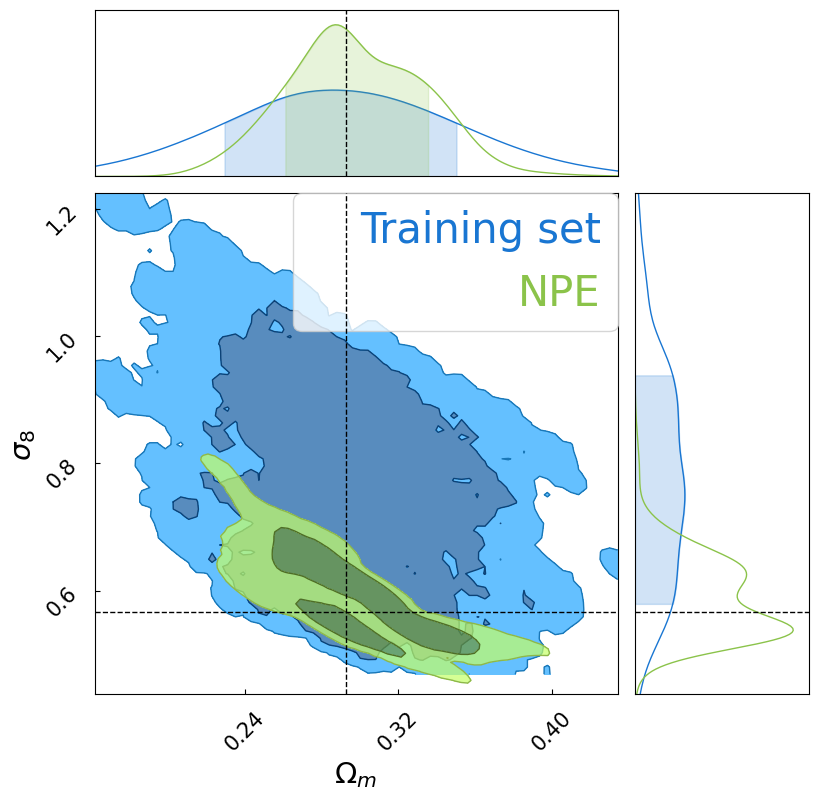

In [28]:
preds_new = scaler.inverse_transform(np.asarray(samples))
params = ["$\Omega_m$", "$\sigma_8$"]


c = ChainConsumer()
c.add_chain(y_cosmo_train,parameters=params,name='Training set')
c.add_chain(preds_new,parameters=params,name='NPE')

# Configure plot
c.configure(label_font_size=21,max_ticks=4,tick_font_size=15,
            legend_kwargs={"frameon":True, "fontsize":30}, kde=True)

fig = c.plotter.plot(figsize=(8.4,8.05), truth=y_cosmo_test[100])

plt.show()